## Project Reinforcement Learning 

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#### Setting up the environment:

- 50kWh of usable capacity 
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh) 
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


# Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give 

In [3]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    return df_long

train = elongate(pd.read_excel('train.xlsx'))
val = elongate(pd.read_excel('validate.xlsx'))


In [4]:
import gym_examples
env = gym.make('gym_examples/BatteryGrid-v0')

env.set_data(train)

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_data to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_data` for environment variables or `env.get_wrapper_attr('set_data')` that will search the reminding wrappers.
  logger.warn(


In [7]:
o['prices'][-1]

24.31

In [11]:
battery_charge = [0]
rewards = [0]

env.reset()
o,r,t,info = env.step(0)

for i in range(len(train)):
    
    if o['prices'][-1] < np.quantile(o['prices'][-100:], 0.25):
        action = 0
    elif o['prices'][-1] > np.quantile(o['prices'][-100:], 0.25) and o['prices'][-1] < np.quantile(o['prices'][-100:], 0.75):
        action = 2
    elif o['prices'][-1] >  np.quantile(o['prices'][-100:], 0.75):
        action = 1
    else:
        action = np.random.randint(0,3)
    
    battery_charge.append(o['battery'])
    rewards.append(r)
    
    o,r,t,info = env.step(action)
    
    if t:
        break
    
    if i > 12000 and i < 12100:
        print(o['prices'][-1], action, o['battery'], r, np.quantile(o['prices'][-100:], 0.25), np.quantile(o['prices'][-100:], 0.75))
    
    # print(o['prices'][-1], action, o['battery'], r)
    # if (i+1) % 100 == 0:
    #     break


37.0 2 22.5 0 30.8775 71.125
30.7 2 22.5 0 30.15 70.28
32.98 2 22.5 0 31.427500000000002 70.28
46.58 2 22.5 0 31.985000000000003 70.28
57.92 2 22.5 0 32.7575 70.28
76.77 2 22.5 0 34.254999999999995 71.125
84.22 1 22.5 -5 35.5125 71.15
90.58 1 22.5 -5 35.917500000000004 71.465
108.0 1 22.5 -5 36.74 73.02
135.0 1 22.5 -5 37.0 75.16
118.58 1 22.5 -5 38.4925 75.6525
119.93 1 22.5 -5 39.004999999999995 77.265
100.5 1 22.5 -5 39.7975 79.0525
97.5 1 22.5 -5 39.7975 80.97
79.96 1 22.5 -5 39.7975 80.97
76.42 2 22.5 0 41.5825 80.97
74.93 2 22.5 0 42.7725 80.97
70.09 2 22.5 0 43.0 80.97
66.87 2 22.5 0 44.1475 80.97
67.79 2 22.5 0 44.6125 80.97
69.99 2 22.5 0 44.6125 80.97
60.0 2 22.5 0 44.6125 80.97
53.59 2 22.5 0 44.6125 80.97
47.28 2 22.5 0 44.6125 80.97
38.02 2 22.5 0 44.1475 80.97
30.8 0 45.0 -1540.0 42.7725 80.97
32.0 0 50.0 -1600.0 42.7725 80.97
46.31 0 50.0 -2315.5 44.1475 80.97
59.0 2 50.0 0 44.6125 80.97
79.5 2 50.0 0 45.66 80.97
81.92 2 50.0 0 46.2325 82.44
103.24 2 50.0 0 46.3700000000

26304

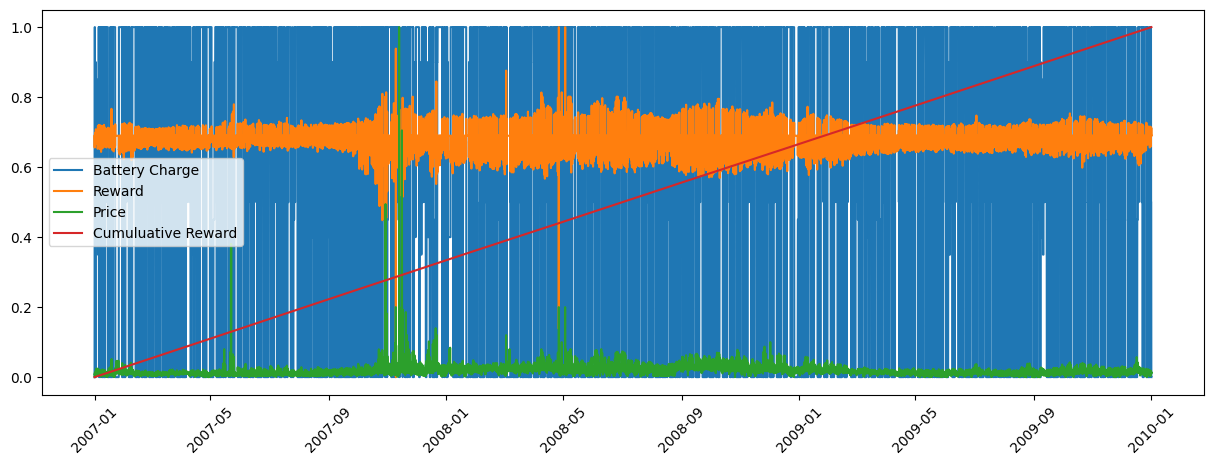

In [17]:
def normalize(data):
    return ((data - np.min(data)) / (np.max(data) - np.min(data)))

battery_charge = normalize(np.array(battery_charge))
rewards = normalize(np.array(rewards))
prices = normalize(np.array(train['price']))
cumulative_reward = normalize(np.cumsum(rewards))

plt.figure(figsize=(15,5))
plt.plot(train['datetime'], battery_charge)
plt.plot(train['datetime'], rewards)
plt.plot(train['datetime'], prices)
plt.plot(train['datetime'], cumulative_reward)
plt.xticks(rotation=45)
plt.legend(['Battery Charge', 'Reward', 'Price', 'Cumuluative Reward'])
plt.show()

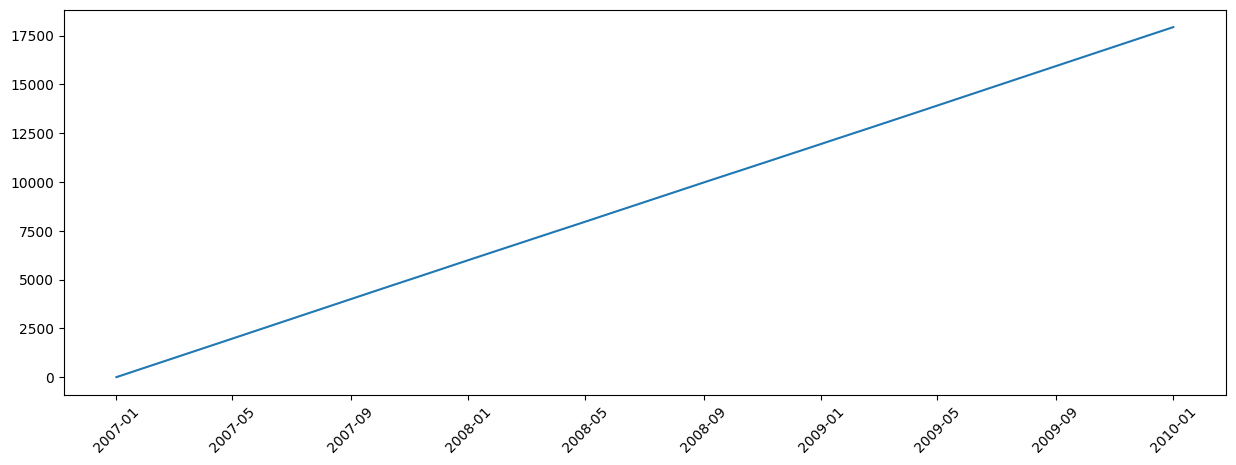

In [13]:
cumulative_reward = np.cumsum(rewards)

plt.figure(figsize=(15,5))
plt.plot(train['datetime'], cumulative_reward)
plt.xticks(rotation=45)
plt.show()

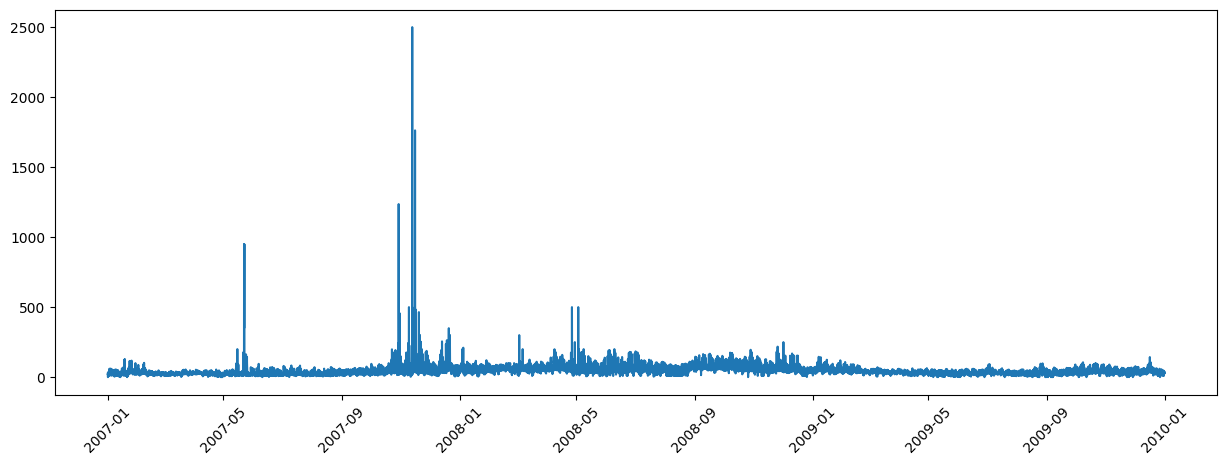

In [51]:
plt.figure(figsize=(15,5))
plt.plot(train['datetime'], train['price'])
plt.xticks(rotation=45)
plt.show()

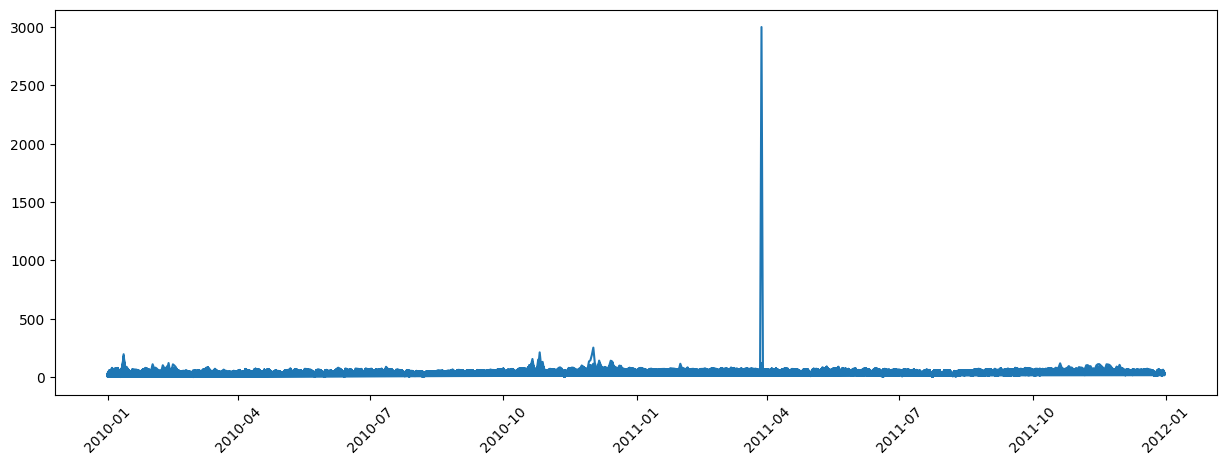

In [32]:
## Plot data
plt.figure(figsize=(15,5))
plt.plot(val['date'], val['price'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
## Rule-based Agent:



In [ ]:
# Feature Engineering: 

# ⁠Gradient of curve 
# Value of to same date last year if available 
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales 
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary 
